<a href="https://colab.research.google.com/github/uu-sml/wasp-assigninmen-af-classification/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Niklas Gunnarsson, Carl Andersson, Daniel Gedon

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color="red">Franco Ruggeri</font>

- **Team ID:** <font color="red">rage95</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart"s health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/42324/assignments/254507

**Due Date:** August 25, 2023.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [ ]:
# @title
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f"{path} already exits. Using cached. Delete it manually to recieve it again!")
    return val

# clone requirements.txt if not yet available
if not exists("requirements.txt"):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# @title
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [ ]:
# @title
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [ ]:
# @title
# 1. Download dataset
if not exists("codesubset.tar.gz"):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

codesubset.tar.gz already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# @title
# 1. unzip the downloaded data set folder
if not exists("codesubset"):
    !tar -xf codesubset.tar.gz

codesubset already exits. Using cached. Delete it manually to recieve it again!


Note that the extraced folder "codesubset" contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [ ]:
# @title
# 2. clone the code files for data preprocessing
if not exists("ecg-preprocessing"):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

ecg-preprocessing already exits. Using cached. Delete it manually to recieve it again!


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

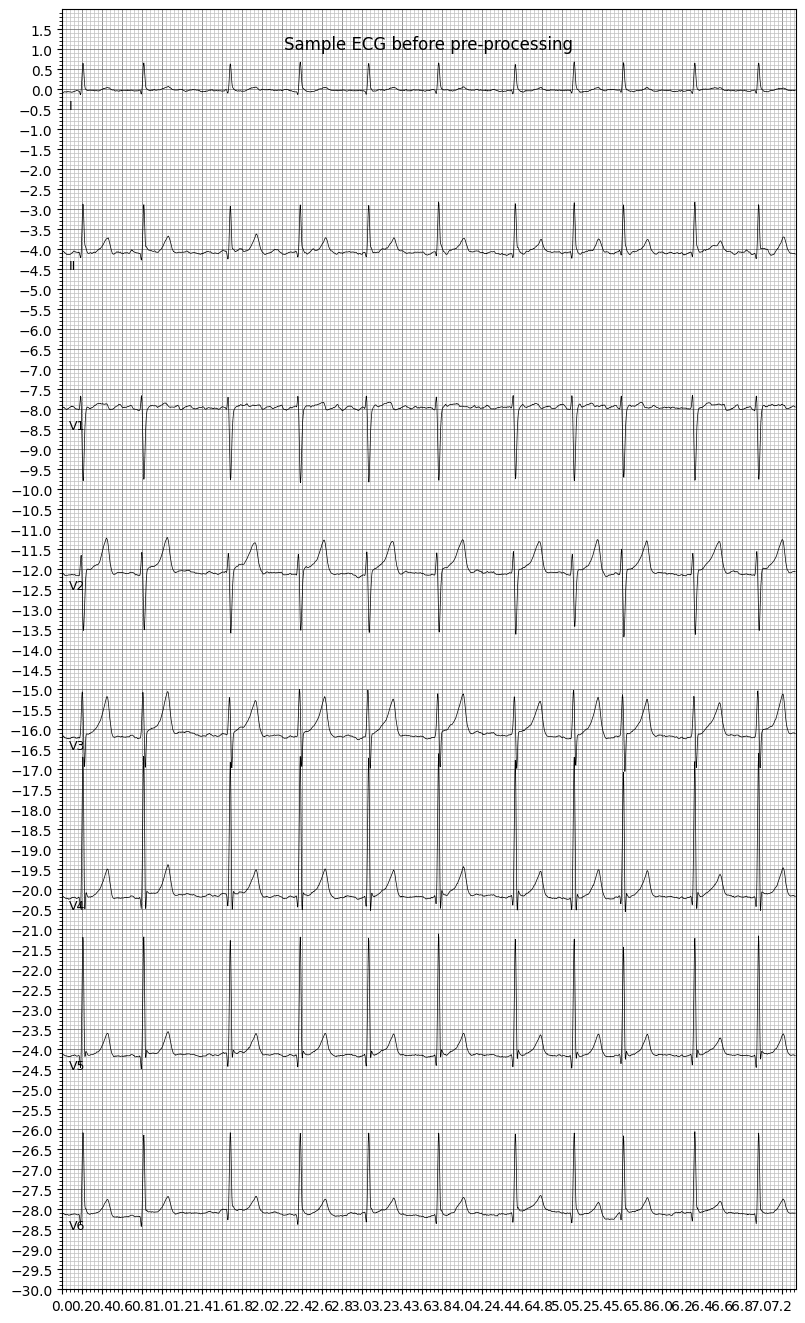

In [ ]:
# @title
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = "codesubset/train/TNMG100046"
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ["I", "II", "V1", "V2", "V3", "V4", "V5", "V6"]
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style="bw", row_height=8, lead_index=lead, columns=1, title="Sample ECG before pre-processing")
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


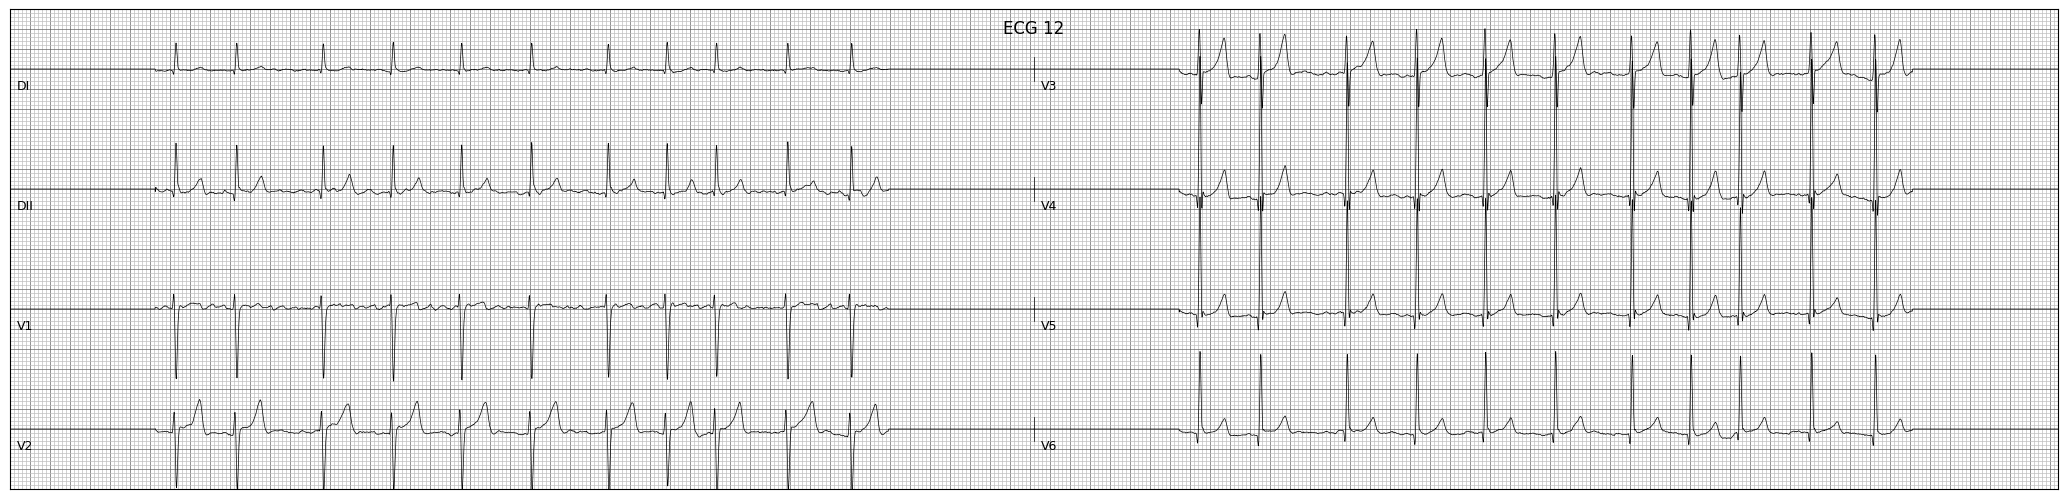

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [ ]:
# @title
# 3. Generate train
if not exists("codesubset/train.h5"):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists("codesubset/test.h5"):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

codesubset/train.h5 already exits. Using cached. Delete it manually to recieve it again!
codesubset/test.h5 already exits. Using cached. Delete it manually to recieve it again!


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = "codesubset/train.h5"
f = h5py.File(PATH_TO_H5_FILE, "r")
data = f["tracings"]
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


Shape: (10000, 4096, 8)
Dtype: float64

Statistics:
            id_exam     id_patient           age           AF
count  1.000000e+04   10000.000000  10000.000000  10000.00000
mean   2.107665e+06   30388.367800     57.929600      0.30000
std    1.408724e+06   50850.448714     17.921952      0.45828
min    4.700000e+01       1.000000     17.000000      0.00000
25%    6.427055e+05    2603.750000     45.000000      0.00000
50%    2.684040e+06    5173.500000     60.000000      0.00000
75%    3.112514e+06   32105.750000     72.000000      1.00000
max    4.416494e+06  195715.000000    103.000000      1.00000


<Figure size 640x480 with 0 Axes>

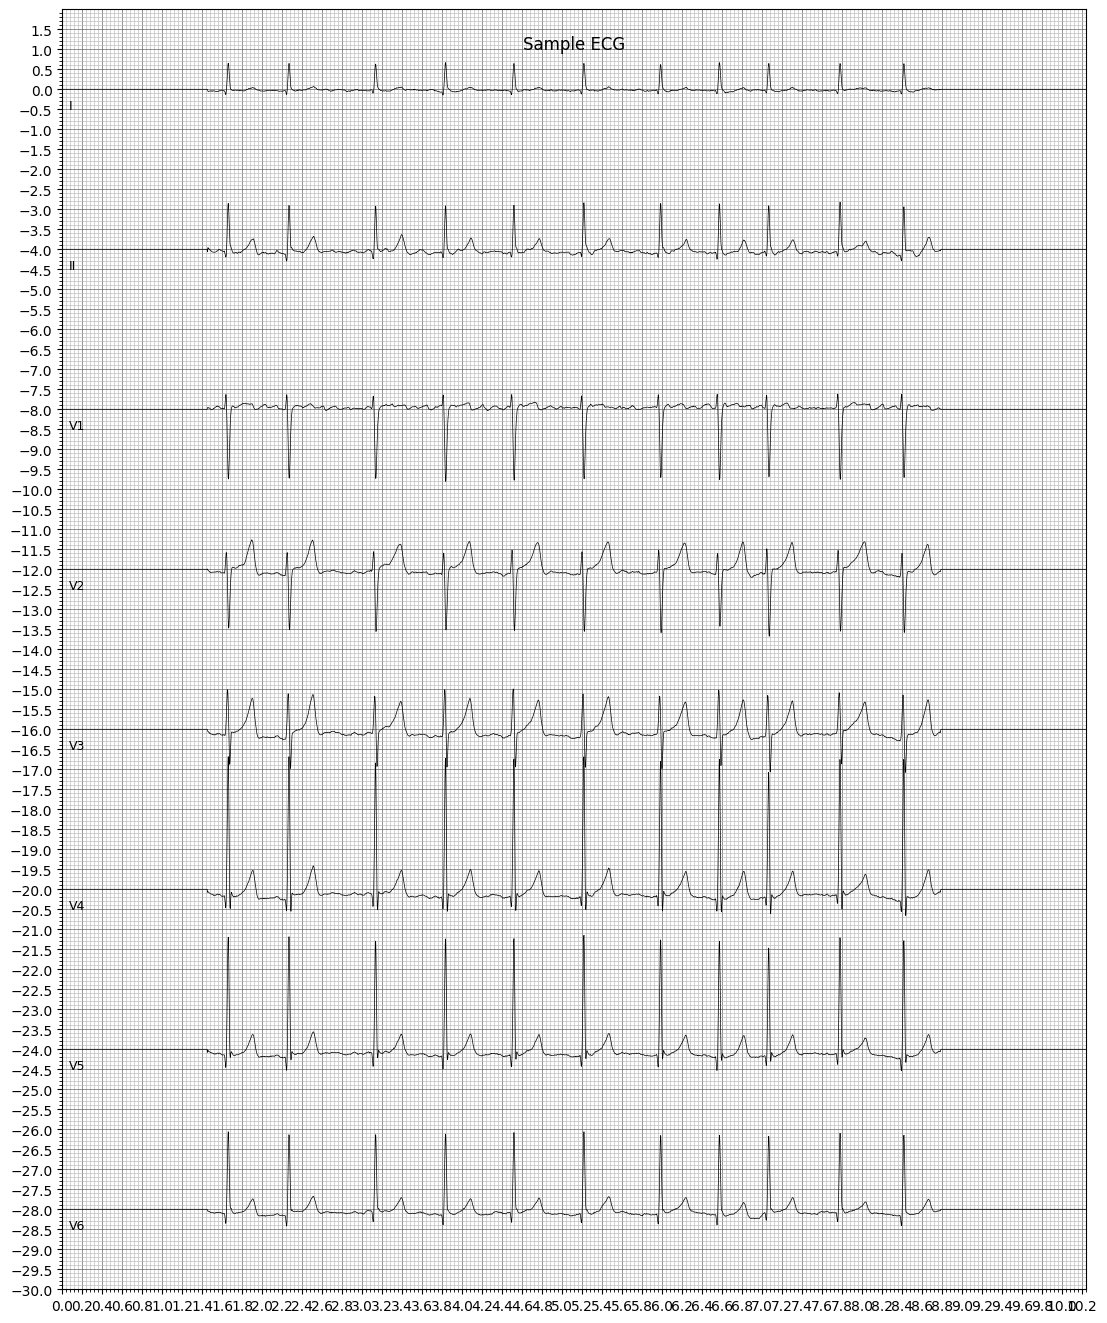

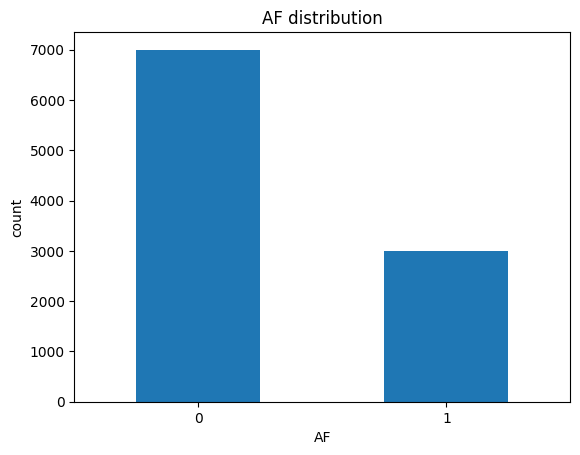

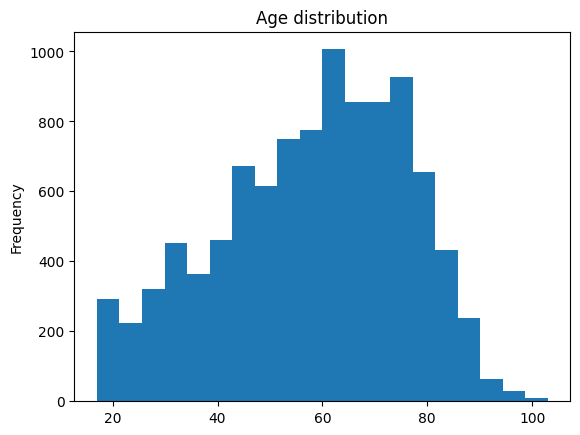

<Figure size 640x480 with 0 Axes>

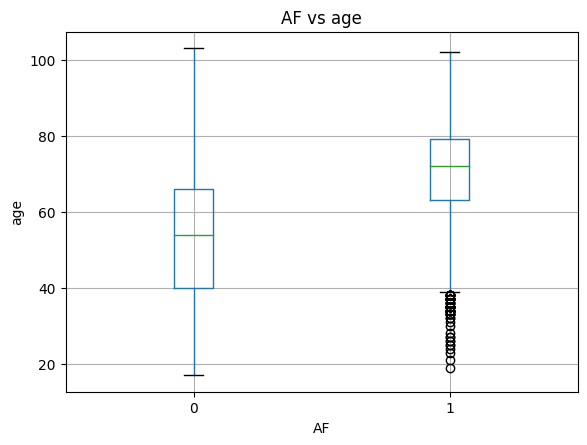

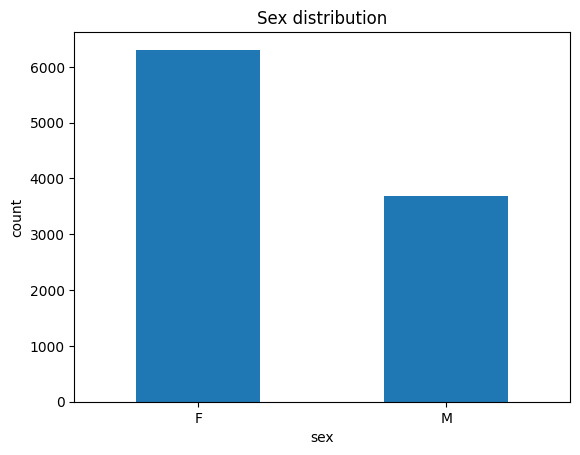

<Figure size 640x480 with 0 Axes>

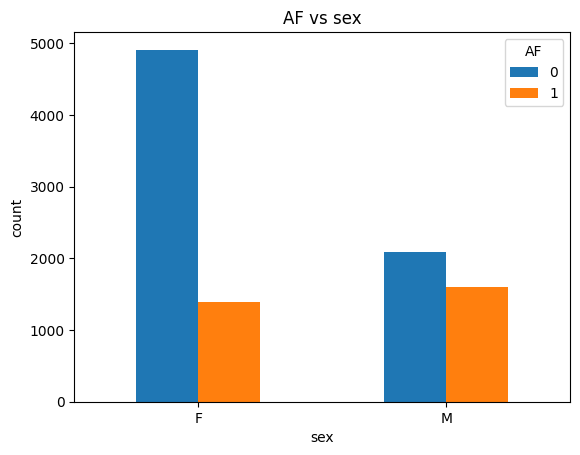

In [ ]:
# @title
"""
TASK: Insert your code here
"""

# Plot a sample ECG
train_traces = h5py.File("codesubset/train.h5", "r")["tracings"]
plt.figure()
ecg_plot.plot(
    ecg=train_traces[0].T,
    sample_rate=400,
    style="bw",
    lead_index=["I", "II", "V1", "V2", "V3", "V4", "V5", "V6"],
    row_height=8,
    columns=1,
    title="Sample ECG",
)

# Statistics
train_data = pd.read_csv("codesubset/train.csv")
print(f"Shape: {train_traces.shape}")
print(f"Dtype: {train_traces.dtype}")
print("\nStatistics:")
print(train_data.describe())

# Class distribution
plt.figure()
train_data["AF"].value_counts().plot(
    kind="bar",
    ylabel="count",
    title="AF distribution",
    rot=0,
)

# Analyze age
plt.figure()
train_data["age"].plot(
    kind="hist",
    bins=20,
    title="Age distribution"
)
plt.figure()
train_data.boxplot(column="age", by="AF")
plt.title("AF vs age")
plt.ylabel("age")
plt.suptitle("")

# Analyze sex
plt.figure()
train_data["sex"].value_counts().plot(
    kind="bar",
    ylabel="count",
    title="Sex distribution",
    rot=False,
)
plt.figure()
train_data.groupby(["sex", "AF"]).size().unstack().plot(
    kind="bar",
    title="AF vs sex",
    ylabel="count",
    rot=0,
)

plt.show()

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color="red">Your explanation here:</font>**

#### Data analysis

The main findings from the data analysis are:
- The dataset is imbalanced. The percentage of samples with AF=0 is 70%.
  Under the assumption that the test set has the same distribution, a
  naive classifier which always predicts "False" would have 70%
  accuracy. This means that the accuracy is not a good metric to
  evaluate a classiifer. Other metrics such as the F1 score are more suitable.
- There is positive correlation between age and AF. In fact, for samples
  with AF=1, the median age is higher than samples with AF=0.
- The sex has a correlation with AF. In fact, the ratio of AF samples is
  much higher for males than females.

Under the assumption that the test set has the same distribution as the
training set, a random guessing classifier would have:
- Precision: 0.3
- Recall: 0.5
- F1: 0.375
- AUROC: 0.5

These values can be used as baselines for trained ML models.

#### Preprocessing

The preprocessing is necessary to enable the ML model to capture the
patterns from the ECGs and the AF presence. Specifically:
- Resampling is necessary to have a common sampling rate in all the ECG
  samples.
- Zero padding is necessary to have the same sequence length in all the
  ECG samples. In fact, most ML models (e.g., neural networks used in
  the following) require a fixed input size.
- Removing trends helps the ML model learn the patterns of heart
  disorder from meaningful variations that aren"t trends.
- Removing power line noise avoids that the ML model overfits noise in
  the ECG samples, which would poorly generalize to unseen data.

---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [ ]:
# @title
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)

    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [ ]:
# @title
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.kernel_size = 16
        seq_len_in = 4096
        in_channels = 8
        out_channels = 128
        n_conv_layers = 5

        conv_layers = []
        for _ in range(n_conv_layers):
            seq_len_out = int(seq_len_in / 2)
            downsample = self._downsample(seq_len_in, seq_len_out)

            conv_layers.append(
                nn.Conv1d(
                  in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=self.kernel_size,
                  stride=downsample,
                  padding=self._padding(downsample),
                  bias=False
              )
            )
            conv_layers.append(nn.BatchNorm1d(num_features=out_channels))
            conv_layers.append(nn.ReLU())

            in_channels = out_channels
            seq_len_in = seq_len_out
        self.conv_layers = nn.Sequential(*conv_layers)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout()

        self.linear = nn.Linear(
            in_features=out_channels * seq_len_out,
            out_features=1
        )

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)

    def forward(self, x):
        x = x.transpose(2,1)
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color="red">Your explanation here:</font>**

The differences of the final model, compared to ModelBaseline, are:
- Deeper architecture: The final model is deeper. It contains 5 convolutional layers (each with a ReLU activation) followed by 1 final linear layer. Each convolution layer downsamples the sequence with a factor of 2. The main idea is to make it easier for the model to learn to extract features at different levels of abstraction. The first convolutional layers should learn low-level features, whereas the last layers should learn on high-level abstractions.
- Larger architecture: The final model is also larger. It uses a larger kernel size of 16 and 128 output channels for each convolutional layer. The main idea for the larger kernel size is to capture patterns in longer windows from the initial layers. With more output channels, instead, we give even more expressiveness to the model.
- More regularization and stability: The final model contains batch normalization layers after each convolutional layer, as well as a dropout layer before the final linear layer. These layers act as regularizers and improve the learning stability, which is crucial given the bigger architecture.

---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [ ]:
# @title
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        outputs = model(traces)

        loss = loss_function(outputs, diagnoses)
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({"loss": total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currently only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the prediction in order to compute other validation metrics in the `main(...)` function.

In [ ]:
# @title
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
            outputs = model(traces)
            loss = loss_function(outputs, diagnoses)
            valid_pred.append(outputs.detach().cpu().numpy())
            valid_true.append(diagnoses.detach().cpu().numpy())

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({"loss": total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color="red">Your explanation here:</font>**

I made some updates on the hyperparameters based on the observed learning curves. Specifically, I made the following changes:
- Decreased the learning rate: The training curves were quite unstable with lr=0.01 (very unstable validation loss, quite flat training loss). By decreasing the learning rate to lr=0.001, they became more stable and smoother (training loss nicely decreasing over the training epochs).
- Given that the model has batch normalization and dropout layers in the model, I reduced the weight decay to 0.01. The performance increased.
- Increased the number of epochs: With the initial value epochs=15, the training loss seemed to had still some potential to decrease. Thus, I updated the number of epochs to 100, which is enough according to the learning curves.

Since the model performance was already satisfying, I did not optimize the hyperparameters further, although an automated hyperparameter optimization (e.g., grid search) would surely be beneficial to take into account correlations among hyperparameters.

In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 100
batch_size = 32

In [ ]:
# @title
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = "codesubset/train.h5", "codesubset/train.csv", "codesubset/train/RECORDS.txt"
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, "r")["tracings"][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split("TNMG")[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index("id_exam", inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df["AF"]), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))

# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
validation_split = 0.2
len_valid = int(len_dataset * validation_split)
dataset_train, dataset_valid = torch.utils.data.random_split(
    dataset=dataset,
    lengths=[len_dataset - len_valid, len_valid]
)

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.014635 	Valid Loss 0.007716 	Valid F1 0.843778 	Valid AUC 0.964499 	Valid AP 0.889742 	Best model -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.007189 	Valid Loss 0.006038 	Valid F1 0.882673 	Valid AUC 0.981418 	Valid AP 0.960806 	Best model -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.005583 	Valid Loss 0.007292 	Valid F1 0.866616 	Valid AUC 0.987383 	Valid AP 0.972925 	


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.004993 	Valid Loss 0.004754 	Valid F1 0.907326 	Valid AUC 0.987017 	Valid AP 0.970534 	Best model -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.004904 	Valid Loss 0.005661 	Valid F1 0.882035 	Valid AUC 0.989278 	Valid AP 0.975476 	


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.004190 	Valid Loss 0.006967 	Valid F1 0.873389 	Valid AUC 0.986429 	Valid AP 0.968082 	


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.004124 	Valid Loss 0.007477 	Valid F1 0.868657 	Valid AUC 0.990533 	Valid AP 0.973056 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.003754 	Valid Loss 0.004137 	Valid F1 0.925806 	Valid AUC 0.990651 	Valid AP 0.979809 	Best model -> saved


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.003730 	Valid Loss 0.003361 	Valid F1 0.942452 	Valid AUC 0.990166 	Valid AP 0.976826 	Best model -> saved


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.003506 	Valid Loss 0.004632 	Valid F1 0.910412 	Valid AUC 0.986097 	Valid AP 0.962615 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.003519 	Valid Loss 0.004364 	Valid F1 0.927066 	Valid AUC 0.988748 	Valid AP 0.966151 	


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.003436 	Valid Loss 0.003512 	Valid F1 0.932231 	Valid AUC 0.990666 	Valid AP 0.977168 	


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.003272 	Valid Loss 0.003379 	Valid F1 0.947368 	Valid AUC 0.989084 	Valid AP 0.972258 	


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.003170 	Valid Loss 0.003601 	Valid F1 0.933113 	Valid AUC 0.990577 	Valid AP 0.976380 	


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.003283 	Valid Loss 0.003511 	Valid F1 0.935193 	Valid AUC 0.992131 	Valid AP 0.980033 	


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 0.003168 	Valid Loss 0.004025 	Valid F1 0.935065 	Valid AUC 0.989252 	Valid AP 0.971509 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 0.003111 	Valid Loss 0.003210 	Valid F1 0.939799 	Valid AUC 0.990780 	Valid AP 0.975471 	Best model -> saved


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 0.003049 	Valid Loss 0.003229 	Valid F1 0.950427 	Valid AUC 0.991438 	Valid AP 0.975701 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 0.003018 	Valid Loss 0.005034 	Valid F1 0.888278 	Valid AUC 0.989459 	Valid AP 0.970636 	


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 0.003031 	Valid Loss 0.002940 	Valid F1 0.946399 	Valid AUC 0.993009 	Valid AP 0.983674 	Best model -> saved


Training Epoch 21:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 21:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21: 	Train Loss 0.003010 	Valid Loss 0.003212 	Valid F1 0.943049 	Valid AUC 0.991168 	Valid AP 0.974984 	


Training Epoch 22:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 22:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22: 	Train Loss 0.002897 	Valid Loss 0.003113 	Valid F1 0.945183 	Valid AUC 0.993496 	Valid AP 0.985504 	


Training Epoch 23:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 23:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23: 	Train Loss 0.002822 	Valid Loss 0.002879 	Valid F1 0.949958 	Valid AUC 0.993345 	Valid AP 0.985986 	Best model -> saved


Training Epoch 24:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 24:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24: 	Train Loss 0.002967 	Valid Loss 0.002934 	Valid F1 0.951324 	Valid AUC 0.992507 	Valid AP 0.979107 	


Training Epoch 25:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 25:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25: 	Train Loss 0.002934 	Valid Loss 0.005289 	Valid F1 0.909804 	Valid AUC 0.990017 	Valid AP 0.970272 	


Training Epoch 26:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 26:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26: 	Train Loss 0.002890 	Valid Loss 0.003585 	Valid F1 0.942192 	Valid AUC 0.990621 	Valid AP 0.970236 	


Training Epoch 27:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 27:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27: 	Train Loss 0.002903 	Valid Loss 0.003548 	Valid F1 0.936170 	Valid AUC 0.990642 	Valid AP 0.978037 	


Training Epoch 28:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 28:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28: 	Train Loss 0.002861 	Valid Loss 0.003095 	Valid F1 0.942548 	Valid AUC 0.992102 	Valid AP 0.978939 	


Training Epoch 29:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 29:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29: 	Train Loss 0.002824 	Valid Loss 0.002996 	Valid F1 0.951157 	Valid AUC 0.992288 	Valid AP 0.975363 	


Training Epoch 30:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30: 	Train Loss 0.002964 	Valid Loss 0.003027 	Valid F1 0.944724 	Valid AUC 0.992623 	Valid AP 0.981005 	


Training Epoch 31:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 31:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31: 	Train Loss 0.002737 	Valid Loss 0.002928 	Valid F1 0.945240 	Valid AUC 0.993115 	Valid AP 0.983252 	


Training Epoch 32:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 32:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32: 	Train Loss 0.002743 	Valid Loss 0.003101 	Valid F1 0.944351 	Valid AUC 0.991784 	Valid AP 0.977690 	


Training Epoch 33:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 33:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33: 	Train Loss 0.002652 	Valid Loss 0.002846 	Valid F1 0.950764 	Valid AUC 0.992720 	Valid AP 0.982878 	Best model -> saved


Training Epoch 34:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 34:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34: 	Train Loss 0.002645 	Valid Loss 0.003178 	Valid F1 0.952709 	Valid AUC 0.992454 	Valid AP 0.978703 	


Training Epoch 35:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 35:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35: 	Train Loss 0.002793 	Valid Loss 0.002973 	Valid F1 0.946218 	Valid AUC 0.992906 	Valid AP 0.980983 	


Training Epoch 36:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 36:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36: 	Train Loss 0.002670 	Valid Loss 0.003175 	Valid F1 0.938474 	Valid AUC 0.993498 	Valid AP 0.983639 	


Training Epoch 37:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 37:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37: 	Train Loss 0.002710 	Valid Loss 0.003307 	Valid F1 0.938315 	Valid AUC 0.991920 	Valid AP 0.980372 	


Training Epoch 38:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 38:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38: 	Train Loss 0.002645 	Valid Loss 0.002951 	Valid F1 0.958012 	Valid AUC 0.991753 	Valid AP 0.979893 	


Training Epoch 39:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 39:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39: 	Train Loss 0.002660 	Valid Loss 0.002863 	Valid F1 0.950378 	Valid AUC 0.993826 	Valid AP 0.986122 	


Training Epoch 40:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 40:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40: 	Train Loss 0.002640 	Valid Loss 0.003132 	Valid F1 0.943333 	Valid AUC 0.992667 	Valid AP 0.983163 	


Training Epoch 41:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 41:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41: 	Train Loss 0.002671 	Valid Loss 0.002916 	Valid F1 0.945000 	Valid AUC 0.993555 	Valid AP 0.982091 	


Training Epoch 42:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 42:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42: 	Train Loss 0.002575 	Valid Loss 0.002971 	Valid F1 0.950735 	Valid AUC 0.992846 	Valid AP 0.980518 	


Training Epoch 43:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 43:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43: 	Train Loss 0.002668 	Valid Loss 0.003085 	Valid F1 0.948247 	Valid AUC 0.991748 	Valid AP 0.977806 	


Training Epoch 44:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 44:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44: 	Train Loss 0.002531 	Valid Loss 0.003127 	Valid F1 0.946755 	Valid AUC 0.992146 	Valid AP 0.981577 	


Training Epoch 45:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 45:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45: 	Train Loss 0.002570 	Valid Loss 0.003030 	Valid F1 0.941764 	Valid AUC 0.993144 	Valid AP 0.983203 	


Training Epoch 46:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 46:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46: 	Train Loss 0.002515 	Valid Loss 0.003433 	Valid F1 0.943958 	Valid AUC 0.991163 	Valid AP 0.976418 	


Training Epoch 47:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 47:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47: 	Train Loss 0.002569 	Valid Loss 0.002867 	Valid F1 0.948247 	Valid AUC 0.993441 	Valid AP 0.985008 	


Training Epoch 48:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 48:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48: 	Train Loss 0.002649 	Valid Loss 0.005149 	Valid F1 0.903636 	Valid AUC 0.990672 	Valid AP 0.964813 	


Training Epoch 49:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 49:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49: 	Train Loss 0.002569 	Valid Loss 0.002946 	Valid F1 0.949958 	Valid AUC 0.992372 	Valid AP 0.979878 	


Training Epoch 50:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50: 	Train Loss 0.002594 	Valid Loss 0.003875 	Valid F1 0.931919 	Valid AUC 0.992130 	Valid AP 0.976795 	


Training Epoch 51:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 51:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51: 	Train Loss 0.002521 	Valid Loss 0.003439 	Valid F1 0.937603 	Valid AUC 0.992773 	Valid AP 0.984116 	


Training Epoch 52:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 52:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52: 	Train Loss 0.002539 	Valid Loss 0.003192 	Valid F1 0.948918 	Valid AUC 0.993338 	Valid AP 0.982326 	


Training Epoch 53:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 53:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53: 	Train Loss 0.002381 	Valid Loss 0.003139 	Valid F1 0.945788 	Valid AUC 0.991892 	Valid AP 0.977126 	


Training Epoch 54:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 54:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54: 	Train Loss 0.002373 	Valid Loss 0.002990 	Valid F1 0.950042 	Valid AUC 0.992228 	Valid AP 0.979099 	


Training Epoch 55:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 55:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55: 	Train Loss 0.002642 	Valid Loss 0.002886 	Valid F1 0.950127 	Valid AUC 0.993007 	Valid AP 0.978628 	


Training Epoch 56:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 56:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56: 	Train Loss 0.002312 	Valid Loss 0.003263 	Valid F1 0.940594 	Valid AUC 0.992358 	Valid AP 0.975756 	


Training Epoch 57:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 57:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57: 	Train Loss 0.002435 	Valid Loss 0.003065 	Valid F1 0.943709 	Valid AUC 0.993066 	Valid AP 0.984353 	


Training Epoch 58:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 58:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58: 	Train Loss 0.002431 	Valid Loss 0.003396 	Valid F1 0.944869 	Valid AUC 0.990040 	Valid AP 0.975339 	


Training Epoch 59:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 59:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59: 	Train Loss 0.002410 	Valid Loss 0.002965 	Valid F1 0.952703 	Valid AUC 0.992527 	Valid AP 0.981639 	


Training Epoch 60:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 60:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60: 	Train Loss 0.002375 	Valid Loss 0.002772 	Valid F1 0.951973 	Valid AUC 0.993645 	Valid AP 0.984078 	Best model -> saved


Training Epoch 61:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 61:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61: 	Train Loss 0.002331 	Valid Loss 0.002956 	Valid F1 0.954740 	Valid AUC 0.992612 	Valid AP 0.977977 	


Training Epoch 62:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 62:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62: 	Train Loss 0.002249 	Valid Loss 0.003032 	Valid F1 0.950628 	Valid AUC 0.992799 	Valid AP 0.980214 	


Training Epoch 63:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 63:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63: 	Train Loss 0.002413 	Valid Loss 0.002701 	Valid F1 0.957699 	Valid AUC 0.993756 	Valid AP 0.984635 	Best model -> saved


Training Epoch 64:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 64:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64: 	Train Loss 0.002236 	Valid Loss 0.002913 	Valid F1 0.953271 	Valid AUC 0.992547 	Valid AP 0.977292 	


Training Epoch 65:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 65:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65: 	Train Loss 0.002205 	Valid Loss 0.003680 	Valid F1 0.938356 	Valid AUC 0.988734 	Valid AP 0.969158 	


Training Epoch 66:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 66:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66: 	Train Loss 0.002333 	Valid Loss 0.003214 	Valid F1 0.940981 	Valid AUC 0.993105 	Valid AP 0.979494 	


Training Epoch 67:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 67:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67: 	Train Loss 0.002303 	Valid Loss 0.003216 	Valid F1 0.936730 	Valid AUC 0.993512 	Valid AP 0.984416 	


Training Epoch 68:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 68:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68: 	Train Loss 0.002322 	Valid Loss 0.002815 	Valid F1 0.952218 	Valid AUC 0.993080 	Valid AP 0.979568 	


Training Epoch 69:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 69:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69: 	Train Loss 0.002311 	Valid Loss 0.003005 	Valid F1 0.947819 	Valid AUC 0.992384 	Valid AP 0.982236 	


Training Epoch 70:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 70:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70: 	Train Loss 0.002340 	Valid Loss 0.002937 	Valid F1 0.949153 	Valid AUC 0.992210 	Valid AP 0.978375 	


Training Epoch 71:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 71:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71: 	Train Loss 0.002107 	Valid Loss 0.003545 	Valid F1 0.936626 	Valid AUC 0.991370 	Valid AP 0.978117 	


Training Epoch 72:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 72:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72: 	Train Loss 0.002265 	Valid Loss 0.002993 	Valid F1 0.951342 	Valid AUC 0.993458 	Valid AP 0.984251 	


Training Epoch 73:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 73:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73: 	Train Loss 0.002282 	Valid Loss 0.003275 	Valid F1 0.941472 	Valid AUC 0.991174 	Valid AP 0.976060 	


Training Epoch 74:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 74:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74: 	Train Loss 0.002214 	Valid Loss 0.002803 	Valid F1 0.957265 	Valid AUC 0.992342 	Valid AP 0.979721 	


Training Epoch 75:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 75:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75: 	Train Loss 0.002214 	Valid Loss 0.003102 	Valid F1 0.954113 	Valid AUC 0.991072 	Valid AP 0.980626 	


Training Epoch 76:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 76:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76: 	Train Loss 0.002191 	Valid Loss 0.002896 	Valid F1 0.950211 	Valid AUC 0.992599 	Valid AP 0.982507 	


Training Epoch 77:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 77:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77: 	Train Loss 0.002152 	Valid Loss 0.003007 	Valid F1 0.955095 	Valid AUC 0.991628 	Valid AP 0.978010 	


Training Epoch 78:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 78:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78: 	Train Loss 0.002100 	Valid Loss 0.003344 	Valid F1 0.942953 	Valid AUC 0.989710 	Valid AP 0.974568 	


Training Epoch 79:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 79:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79: 	Train Loss 0.002164 	Valid Loss 0.003303 	Valid F1 0.940692 	Valid AUC 0.993015 	Valid AP 0.984077 	


Training Epoch 80:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 80:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80: 	Train Loss 0.002192 	Valid Loss 0.003184 	Valid F1 0.948247 	Valid AUC 0.991963 	Valid AP 0.981301 	


Training Epoch 81:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 81:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81: 	Train Loss 0.001979 	Valid Loss 0.002898 	Valid F1 0.954315 	Valid AUC 0.992376 	Valid AP 0.980713 	


Training Epoch 82:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 82:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82: 	Train Loss 0.002118 	Valid Loss 0.002779 	Valid F1 0.950847 	Valid AUC 0.993700 	Valid AP 0.984750 	


Training Epoch 83:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 83:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83: 	Train Loss 0.001985 	Valid Loss 0.003040 	Valid F1 0.954113 	Valid AUC 0.990857 	Valid AP 0.981658 	


Training Epoch 84:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 84:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84: 	Train Loss 0.002023 	Valid Loss 0.003099 	Valid F1 0.954740 	Valid AUC 0.991374 	Valid AP 0.973577 	


Training Epoch 85:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 85:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85: 	Train Loss 0.001906 	Valid Loss 0.003094 	Valid F1 0.947014 	Valid AUC 0.991417 	Valid AP 0.980352 	


Training Epoch 86:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 86:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86: 	Train Loss 0.002027 	Valid Loss 0.002751 	Valid F1 0.955707 	Valid AUC 0.993519 	Valid AP 0.983985 	


Training Epoch 87:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 87:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87: 	Train Loss 0.001936 	Valid Loss 0.003704 	Valid F1 0.931148 	Valid AUC 0.992316 	Valid AP 0.982755 	


Training Epoch 88:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 88:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88: 	Train Loss 0.001881 	Valid Loss 0.003643 	Valid F1 0.929739 	Valid AUC 0.992353 	Valid AP 0.985033 	


Training Epoch 89:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 89:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89: 	Train Loss 0.001913 	Valid Loss 0.003551 	Valid F1 0.934211 	Valid AUC 0.991697 	Valid AP 0.983356 	


Training Epoch 90:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 90:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90: 	Train Loss 0.001886 	Valid Loss 0.002867 	Valid F1 0.949958 	Valid AUC 0.993192 	Valid AP 0.984483 	


Training Epoch 91:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 91:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91: 	Train Loss 0.001952 	Valid Loss 0.003244 	Valid F1 0.948610 	Valid AUC 0.991366 	Valid AP 0.974939 	


Training Epoch 92:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 92:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92: 	Train Loss 0.001967 	Valid Loss 0.002977 	Valid F1 0.950512 	Valid AUC 0.991838 	Valid AP 0.983288 	


Training Epoch 93:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 93:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93: 	Train Loss 0.001835 	Valid Loss 0.003120 	Valid F1 0.951890 	Valid AUC 0.991333 	Valid AP 0.979730 	


Training Epoch 94:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 94:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94: 	Train Loss 0.001795 	Valid Loss 0.003259 	Valid F1 0.942452 	Valid AUC 0.991542 	Valid AP 0.977070 	


Training Epoch 95:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 95:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95: 	Train Loss 0.001866 	Valid Loss 0.004569 	Valid F1 0.924342 	Valid AUC 0.985360 	Valid AP 0.961827 	


Training Epoch 96:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 96:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96: 	Train Loss 0.001941 	Valid Loss 0.003132 	Valid F1 0.953368 	Valid AUC 0.991113 	Valid AP 0.982547 	


Training Epoch 97:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 97:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97: 	Train Loss 0.001813 	Valid Loss 0.002947 	Valid F1 0.950847 	Valid AUC 0.991718 	Valid AP 0.981898 	


Training Epoch 98:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 98:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98: 	Train Loss 0.001689 	Valid Loss 0.003707 	Valid F1 0.934979 	Valid AUC 0.990943 	Valid AP 0.979230 	


Training Epoch 99:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 99:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99: 	Train Loss 0.001827 	Valid Loss 0.003458 	Valid F1 0.947189 	Valid AUC 0.989102 	Valid AP 0.975001 	


Training Epoch 100:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100: 	Train Loss 0.001726 	Valid Loss 0.003182 	Valid F1 0.952951 	Valid AUC 0.990913 	Valid AP 0.980692 	


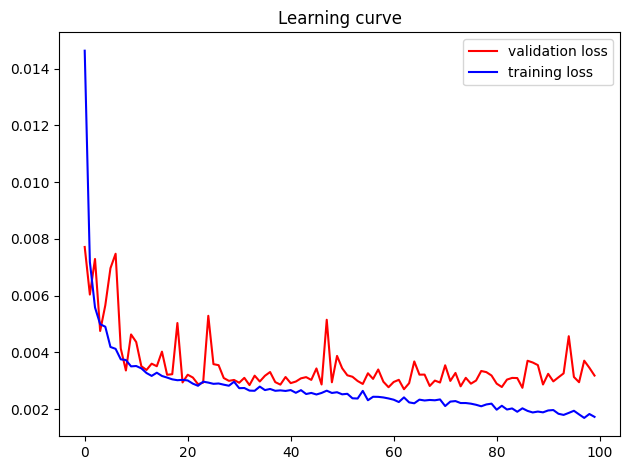

In [ ]:
# @title
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, .99)

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    probs = nn.Sigmoid()(torch.from_numpy(y_pred))
    y_pred_hard = probs > 0.5   # class predictions
    valid_f1 = metrics.f1_score(y_true, y_pred_hard)
    valid_auc = metrics.roc_auc_score(y_true, y_pred)
    valid_ap = metrics.average_precision_score(y_true, y_pred)

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({"model": model.state_dict()}, "model.pth")
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write(
        f"Epoch {epoch:2d}: \t"
        f"Train Loss {train_loss:.6f} \t"
        f"Valid Loss {valid_loss:.6f} \t"
        f"Valid F1 {valid_f1:.6f} \t"
        f"Valid AUC {valid_auc:.6f} \t"
        f"Valid AP {valid_ap:.6f} \t"
        f"{model_save_state}"
    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
plt.figure()
plt.plot(valid_loss_all, color="r",  label="validation loss")
plt.plot(train_loss_all, color="b", label="training loss")
plt.title("Learning curve")
plt.legend()
plt.tight_layout()
plt.show()

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard prediction (0,1) instead of soft predictions (probabilities).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model.
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [ ]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = "codesubset/test.h5", "codesubset/test.csv"
traces = torch.tensor(h5py.File(path_to_h5_test, "r")["tracings"][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [ ]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()

# load stored model parameters
ckpt = torch.load("model.pth", map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt["model"])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn"t count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
if not exists("leaderboard"):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

leaderboard already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = "rage95"
password = "hejhej"

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")
else:
    print(r)

<Response [200]>


In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = "LRScheduler"

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")
else:
    print("Failed")

Submission updated!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color="red">Your explanation here:</font>**

Your team id: **<font color="red">rage95</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|3Conv+BN+Dropout+FC              | 0.927        | 0.924  | 0.976   | 0.970 | Deeper architecture with regularization (batch norm and dropout layers)                   |
|LargerKernel              | 0.949 | 0.948        | 0.987  | 0.985   | Enlarged architecture (kernel size and output channels)                   |
|LRScheduler              | 0.948        | 0.947  | 0.986   | 0.983  | Learning rate exponential decay                   |

1. Compared to the model baseline:
  - I made the model deeper (5 hidden convolutional layers instead of 1) to have more non-linearity and capture high-level and low-level patterns in the sequence.
  - I added more regularization (batch normalization and dropout layers) to prevent overfitting.
2. Compared to submission 1:
  - I increased the kernel size (from 3 to 16) to capture patterns in longer slices of the sequences also in the initial layers.
  - I increased the output channels (from 32 to 128) to have even more expressiveness.
  - I increased the number of epochs (from 20 to 100).
3. Compared to submission 2, I added the learning rate scheduler to
   exponentially decay it. In this way, over time, the learning rate
   gets smaller and the optimizer should be able to get closer to a
   local optimum. The result was slightly better on the validation set,
   but slightly worse on the test set. Decaying the learning rate does
   not have much impact most likely because Adam already has an adaptive
   effective learning rate.

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color="red">Your explanation here:</font>**

- AUC is threshold agnostic (it considers the whole range of thresholds), so it provides a general overview of the performance. This is extremely useful in applications where the threshold might vary. However, it does not consider precision and recall directly so, in the case of imbalanced datasets, it can be misleading.
- F1 depends on a specific probability threshold (0.5 in my experiments) and clearly indicates the performance in terms of precision and recall for that specific threshold. It handles very well imbalanced datasets giving importance to both false positives and false negatives. However, it does not provide an overview of the performance provided by varying the threshold.
- AP, like F1, considers precision and recall, which is suitable for imbalanced datasets. It is threshold agnostic like AUC.

The three metrics should all be considered, as they evaluate the model from different and complementary angles.